In [1]:
import numpy as np
from qiskit import *
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
from POVMMeasure import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from SequentialPOVMMeasurement import SequentialPOVMMeasurement

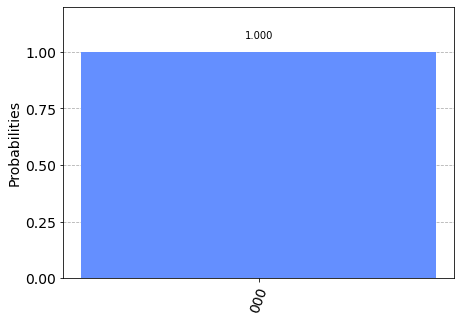

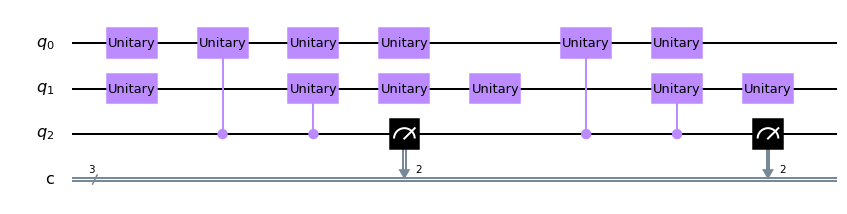

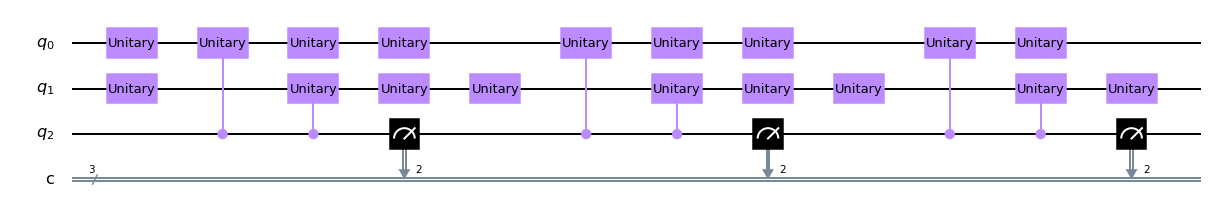

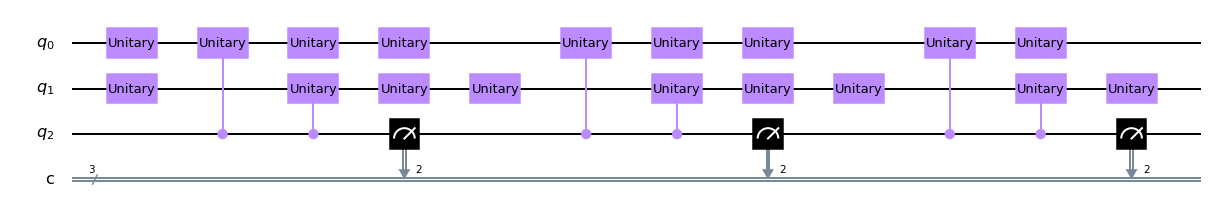

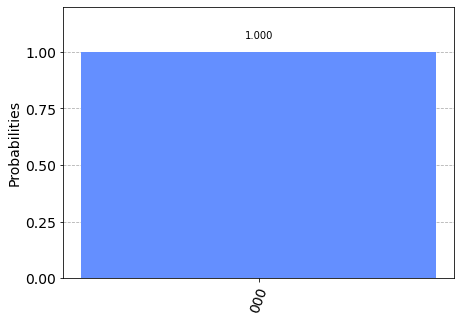

In [2]:

povm_effects = [
    np.array([[1/6, 1/6],
              [1/6, 1/6]]),
    np.array([[1/6, -1/6],
              [-1/6, 1/6]]),
    np.array([[1/6, 0+(-1j/6)],
              [0+(1j/6), 1/6]]),
    np.array([[1/6, 0+(-1j/6)],
              [0+(1j/6), 1/6]]),
    np.array([[1/3, 0],
              [0, 0]]),
    np.array([[0, 0],
              [0, 1/3]])
]

seq = SequentialPOVMMeasurement(povm_effects, [1, 2, 3, 4, 5, 6])
circuits = seq.make_circuits([[1, 4], [[2, 5], [3, 6]]])
circuits[0].draw('mpl')
circuits[1].draw('mpl')
circuits[2].draw('mpl')


qasm = qiskit.Aer.get_backend("qasm_simulator")
job = qiskit.execute(circuits[0], qasm, shots=1000)
plot_histogram(job.result().get_counts())


